In [1]:
%%capture
%load_ext autoreload
%autoreload 2
# %cd ..
import sys
sys.path.append("..")
import statnlpbook.util as util
util.execute_notebook('language_models.ipynb')
# import tikzmagic
%load_ext tikzmagic
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\prob}{p}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
$$

# Language Models

## Language Models

calculate the **probability of seeing a sequence of words**. 

For example: how likely is the following sequence?

> We're going to win bigly. 

Is it more likely than this one?

> We're going to win big league.

## Use Cases: Machine Translation

> Wir werden haushoch gewinnen

translates to?

> We will win by a mile

or 

> We will win bigly

## Use Cases: Speech Recognition

What did he [say](https://www.theguardian.com/us-news/video/2016/may/04/donald-trump-we-are-going-to-win-bigly-believe-me-video)?

> We're going to win bigly

or

> We're going to win big league

## Use Cases: Natural Language Generation

https://twitter.com/deepdrumpf

Other applications?

## Formally
Models the probability 

$$\prob(w_1,\ldots,w_d)$$ 

of observing sequences of words \\(w_1,\ldots,w_d\\). 

Without loss of generality: 

\begin{align}
\prob(w_1,\ldots,w_d) &= p(w_1) p(w_2|w_1) p(w_3|w_1, w_2) \ldots \\
 &= \prob(w_1) \prod_{i = 2}^d \prob(w_i|w_1,\ldots,w_{i-1})
\end{align}

### Structured Prediction

predict word $y=w_i$ 
* conditioned on history $\x=w_1,\ldots,w_{i-1}$.

## N-Gram Language Models

Impossible to estimate sensible probability for each history 

$$
\x=w_1,\ldots,w_{i-1}
$$

### Change **representation**
truncate history to last $n-1$ words: 

$$
\mathbf{f}(\x)=w_{i-(n-1)},\ldots,w_{i-1}
$$

$\prob(\text{bigly}|\text{...,blah, blah, blah, we, will, win}) 
= \prob(\text{bigly}|\text{we, will, win})$

### Unigram LM

Set $n=1$:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i).
$$

$\prob(\text{bigly}|\text{we, will, win}) = \prob(\text{bigly})$

## Uniform LM
Same probability for each word in a *vocabulary* \\(\vocab\\):

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \frac{1}{|\vocab|}.
$$

$\prob(\text{big}) = \prob(\text{bigly}) = \frac{1}{|\vocab|}$

Let us look at a training set and create a uniform LM from it.

In [2]:
train[:10]

['[BAR]', 'Can', "'t", 'even', 'call', 'this', 'a', 'blues', 'song', '[/BAR]']

In [3]:
vocab = set(train)
baseline = UniformLM(vocab)
sum([baseline.probability(w) for w in vocab])

0.9999999999999173

What about other words? Summing up probabilities?

## Sampling
* Sampling from an LM is easy and instructive
* Usually, the better the LM, the better the samples

Sample **incrementally**, one word at a time 

In [4]:
def sample_once(lm, history, words):
    probs = [lm.probability(word, *history) for word in words]
    return np.random.choice(words,p=probs)

In [5]:
sample_once(baseline, [], list(baseline.vocab))    

'east'

In [6]:
def sample(lm, initial_history, amount_to_sample):
    words = list(lm.vocab)
    result = []
    result += initial_history
    for _ in range(0, amount_to_sample):
        history = result[-(lm.order - 1):]
        result.append(sample_once(lm,history,words))
    return result

In [7]:
sample(baseline, [], 10)

['sword',
 'everytime',
 'brutality',
 'Well',
 'breast',
 'neck',
 'alcohol',
 'stiff',
 'baron',
 'system']

## Evaluation
* **Extrinsic**: how it improves a downstream task?
* **Intrinsic**: how good does it model language?

## Intrinsic Evaluation
**Shannon Game**: Predict next word, win if prediction match words in actual corpus (or you gave it high probability)

> Our horrible trade agreements with [???]

Formalised by ...

### Perplexity 
Given test sequence \\(w_1,\ldots,w_T\\), perplexity \\(\perplexity\\) is **geometric mean of inverse probabilities**:

\begin{align}
\perplexity(w_1,\ldots,w_T) &= \sqrt[T]{\frac{1}{\prob(w_1)} \frac{1}{\prob(w_2|w_1)} \ldots} \\
&= \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i|w_{i-n},\ldots,w_{i-1})}}
\end{align}

### Interpretation

Consider LM where 
* at each position there are exactly **2** words with $\frac{1}{2}$ probability
* in test sequence, one of these is always the true word 

Then 

* $\perplexity(w_1,\ldots,w_T) = \sqrt[T]{2 \cdot 2  \cdot\ldots} = 2$
* Perplexity $\approx$ average number of choices

Perplexity of uniform LM on an **unseen** test set?

In [8]:
perplexity(baseline, test)

inf

Problem: model assigns **zero probability** to words not in the vocabulary. 

In [9]:
[(w,baseline.probability(w)) for w in test if w not in vocab][:3]

[('does', 0.0), ('Ceremonies', 0.0), ('Masquerading', 0.0)]

## The Long Tail
New words not specific to our corpus: 
* long **tail** of words that appear only a few times
* each has low probability, but probability of seeing any long tail word is high


Let us plot word frequency ranks (x-axis) against frequency (y-axis) 

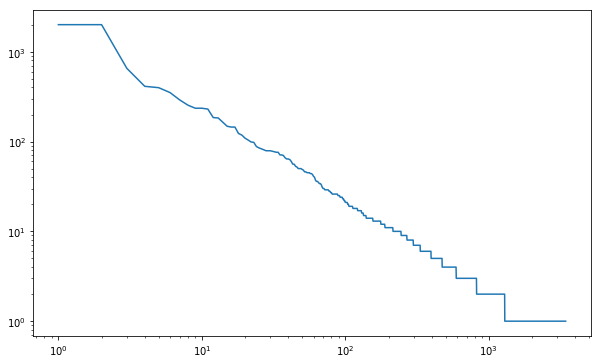

In [10]:
plt.xscale('log')
plt.yscale('log') 
plt.plot(ranks, sorted_counts)

In log-space such rank vs frequency graphs are **linear** 

* Known as **Zipf's Law**

Let $r_w$ be the rank of a word \\(w\\), and \\(f_w\\) its frequency:

$$
  f_w \propto \frac{1}{r_w}.
$$

* Also true in [random text](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.164.8422&rep=rep1&type=pdf)

## Out-of-Vocabularly (OOV) Tokens
There will always be words with zero counts in your training set.

Solutions:
* Remove unseen words from test set (bad)
* Move probability mass to unseen words (good, discuss later)
* Replace unseen words with out-of-vocabularly token, estimate its probability

### Inserting OOV Tokens

In [11]:
replace_OOVs(baseline.vocab, test[:10])

['[BAR]',
 'scratched',
 '[/BAR]',
 '[BAR]',
 'What',
 '[OOV]',
 'it',
 'take',
 '[/BAR]',
 '[BAR]']

What happens to perplexity if training set is small?

### Estimate `OOV` probability
What is the probability of seeing a word you haven't seen before?

Consider the "words"

> AA AA BB BB AA

Going left to right, how often do I see new words?

Inject `OOV` tokens to mark these "new word events"

In [12]:
inject_OOVs(["AA","AA","BB","BB","AA"])

['[OOV]', 'AA', '[OOV]', 'BB', 'AA']

Now train on replaced data...

In [13]:
oov_train = inject_OOVs(train)
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, test)
oov_baseline = UniformLM(oov_vocab)
perplexity(oov_baseline,oov_test)

1290.0000000049852

What does this perplexity correspond to?

## Training N-Gram Language Models

N-gram language models condition on a limited history: 

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i|w_{i-(n-1)},\ldots,w_{i-1}).
$$

What are its parameters (continuous values that control its behaviour)?

One parameter $\param_{w,h}$ for each word $w$ and history $h=w_{i-(n-1)},\ldots,w_{i-1}$ pair:

$$
\prob_\params(w|h) = \param_{w,h}
$$

$\prob_\params(\text{bigly}|\text{win}) = \param_{\text{bigly, win}}$

### Maximum Likelihood Estimate

Assume training set \\(\train=(w_1,\ldots,w_d)\\)

### Maximum Likelihood Estimate

Find \\(\params\\) that maximizes the log-likelihood of \\(\train\\):

$$
\params^* = \argmax_\params \log p_\params(\train)
$$

where

$$
\prob_\params(\train) = \ldots \prob_\params(w_i|\ldots w_{i-1}) \prob_\params(w_{i+1}|\ldots w_{i}) \ldots 
$$

**Structured Prediction**: this is your continuous optimization problem!

Maximum-log-likelihood estimate (MLE) can be calculated in **[closed form](/notebooks/chapters/mle.ipynb)**:
$$
\prob_{\params^*}(w|h) = \param^*_{w,h} = \frac{\counts{\train}{h,w}}{\counts{\train}{h}} 
$$

where 

$$
\counts{D}{e} = \text{Count of } e \text{ in }  D 
$$

Many LM variants: different estimation of counts. 

## Training a Unigram Model
Let us train a unigram model...

What do you think the most probable words are? 

Remember our training set looks like this ...

In [14]:
oov_train[10000:10010]

['[BAR]', 'I', '[OOV]', 'at', 'home', 'but', 'I', 'gotta', 'escape', '[/BAR]']

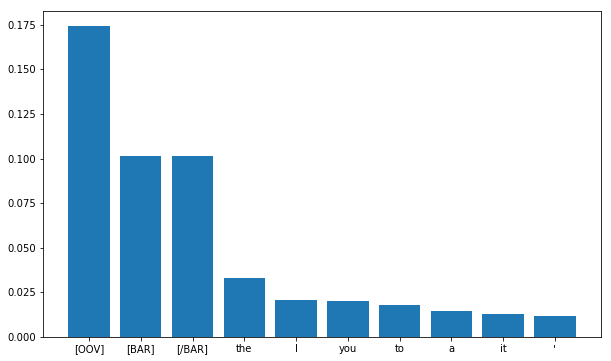

In [15]:
unigram = NGramLM(oov_train,1)
plot_probabilities(unigram)
# sum([unigram.probability(w) for w in unigram.vocab])

The unigram LM has substantially reduced (and hence better) perplexity:

In [16]:
perplexity(unigram,oov_test)

91.4414922652717

Its samples look (a little) more reasonable:

In [17]:
sample(unigram, [], 10)

['[OOV]',
 '[OOV]',
 '[OOV]',
 '[OOV]',
 '[OOV]',
 'your',
 'ways',
 'is',
 '[BAR]',
 'life']

## Bigram Model
We can do better by setting $n=2$

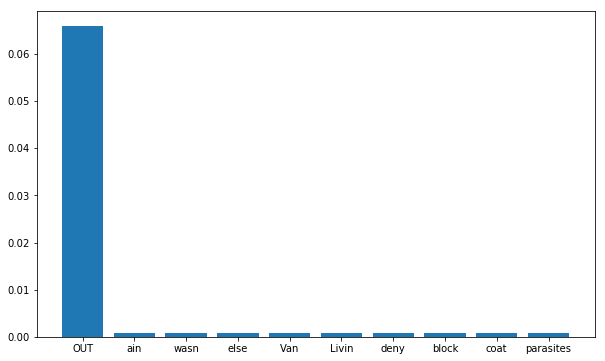

In [18]:
bigram = NGramLM(oov_train,2)
plot_probabilities(laplace_bigram, ("FIND",)) #I, FIND, laplace .. 

Samples should look (slightly) more fluent:

In [19]:
" ".join(sample(laplace_bigram, ['FIND'], 30)) # try: I, FIND

'FIND coming music ten through [/BAR] [BAR] [/BAR] [BAR] stroke roam erased Maintain talk another same stay Listening commercial PE-DA-DEE-DA-DEE-DA-DEE-DA-DEECE Shit school passed pain great Singing sayin Hey PE album mathematics'

How about perplexity?

In [20]:
perplexity(bigram,oov_test)

inf

Some contexts where OOV word (and others) haven't been seen, hence 0 probability...

In [21]:
bigram.probability("[OOV]","money")

0.0

## Smoothing

Maximum likelihood 
* **underestimates** true probability of some words 
* **overestimates** the probabilities of other

Solution: _smooth_ the probabilities and **move mass** from seen to unseen events.

### Laplace Smoothing

Add **pseudo counts** to each event in the dataset 

$$
\param^{\alpha}_{w,h} = \frac{\counts{\train}{h,w} + \alpha}{\counts{\train}{h} + \alpha \lvert V \rvert } 
$$

Bayesian view: *maximum posteriori* estimate under a dirichlet prior on parameters.

In [22]:
laplace_bigram = LaplaceLM(bigram, 0.1) 
laplace_bigram.probability("[OOV]","money")

0.0007692307692307692

Perplexity should look better now:

In [23]:
perplexity(LaplaceLM(bigram, 0.001),oov_test)

93.79512094464789

### Example
Consider three events:

In [24]:
c  = ["word",         "train count", "MLE",  "Laplace", "Same Denominator"]
r1 = ["smally",       "0",           "0/3",    "1/6",       "0.5/3"]
r2 = ["bigly",        "1",           "1/3",    "2/6",       "1/3"]
r3 = ["tremendously", "2",           "2/3",    "3/6",       "1.5/3"]
util.Table([r1,r2,r3], column_names=c)

word,train count,MLE,Laplace,Same Denominator
smally,0,0/3,1/6,0.5/3
bigly,1,1/3,2/6,1/3
tremendously,2,2/3,3/6,1.5/3


How is mass moved for Laplace Smoothing?

Events with higher counts get penalised more!

Is this consistent with how counts behave on an unseen test?

In [25]:
util.Table(frame, column_names = ["Train Count", "Test Count", "Laplace Count"], number_format="{0:.4f}")

Train Count,Test Count,Laplace Count
0,0.0034,0.0050
1,0.4375,0.3019
2,1.1152,0.7546
3,1.6615,1.2125
4,2.6753,1.5728
5,4.1019,2.2806
6,4.6883,2.5625
7,5.3929,3.5774


Penalty is closer to being constant than increasing by count:
* Test counts usually between 0.6 and 1.4 smaller than train counts
* In larger datasets this can be a constant!

So "real" re-allocation looks more like this:

### Interpolation
* Laplace Smoothing assigns mass **uniformly** to the words that haven't been seen in a context.

In [26]:
laplace_bigram.probability('rhyme','man'), \
laplace_bigram.probability('of','man')

(0.0005649717514124294, 0.0005649717514124294)

Not all unseen words (in a context) are equal

With **interpolation** We can do better: 
* give more mass to words likely under the $n-1$-gram model. 
    * Use $\prob(\text{of})$ for estimating $\prob(\text{of} | \text{man})$
* Combine $n$-gram model \\(p'\\) and a back-off \\(n-1\\) model \\(p''\\): 

$$
\prob_{\alpha}(w_i|w_{i-n+1},\ldots,w_{i-1}) = \alpha \cdot \prob'(w_i|w_{i-n+1},\ldots,w_{i-1}) + \\ (1 - \alpha) \cdot \prob''(w_i|w_{i-n+2},\ldots,w_{i-1})
$$


In [27]:
interpolated = InterpolatedLM(bigram,unigram,0.01)
interpolated.probability('rhyme','man'), \
interpolated.probability('of','man')

(0.001156307129798903, 0.007390310786106033)

Can we find a good $\alpha$ parameter? Tune on some **development set**!

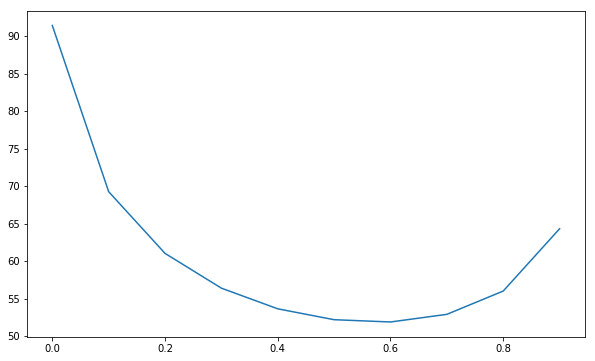

In [28]:
alphas = np.arange(0,1.1,0.1)
perplexities = [perplexity(InterpolatedLM(bigram,unigram,alpha),oov_test) 
                for alpha in alphas]
plt.plot(alphas,perplexities)

### Backoff 
* When we have counts for an event, trust these counts and not the simpler model
    * use $\prob(\text{bigly}|\text{win})$ if you have seen $(\text{win, bigly})$, not $\prob(\text{bigly})$
* **back-off** only when no counts for a given event are available.

### Stupid Backoff
Let \\(w\\) be a word and \\(h_{m}\\) an n-gram of length \\(m\\):  

$$
\prob_{\mbox{Stupid}}(w|h_{m}) = 
\begin{cases}
\frac{\counts{\train}{h_{m},w}}{\counts{\train}{h_{m}}}  &= \mbox{if }\counts{\train}{h_{m},w} > 0 \\\\
\prob_{\mbox{Stupid}}(w|h_{m-1}) & \mbox{otherwise}
\end{cases}
$$

What is the problem with this model?

In [29]:
stupid = StupidBackoff(bigram, unigram, 0.1)
sum([stupid.probability(word, 'the') for word in stupid.vocab])

1.0647115579930924

### Absolute Discounting
Recall that in test data, a constant probability mass is taken away for each non-zero count event. Can this be captured in a smoothing algorithm?

Yes: subtract (tunable) constant $d$ from each non-zero probability:

$$
\prob_{\mbox{Absolute}}(w|h_{m}) = 
\begin{cases}
\frac{\counts{\train}{h_{m},w}-d}{\counts{\train}{h_{m}}}   &= \mbox{if }\counts{\train}{h_{m},w} > 0 \\\\
\alpha(h_{m-1})\cdot\prob_{\mbox{Absolute}}(w|h_{m-1}) & \mbox{otherwise}
\end{cases}
$$

$\alpha(h_{m-1})$ is a normalizer

### Unigram Backoff

Assume, for example:
* *Mos Def* is a rapper name that appears often in the data
* *glasses* appears slightly less often
* neither Def nor glasses have been seen in the context of the word *reading*

Then the final-backoff unigram model might assign a higher probability to

> I can't see without my reading Def

than

> I can't see without my reading glasses

because $\prob(\text{Def}) > \prob(\text{glasses})$

But *Def* never follows anything but *Mos*, and we can determine this by looking at the training data!

### Knesser Ney Smoothing

Absolute Discounting, but use as final backoff probability the probability that a word appears after (any) word in the training set: 

$$
\prob_{\mbox{KN}}(w) = \frac{\left|\{w_{-1}:\counts{\train}{w_{-1},w}> 1\}  \right|}
{\sum_{w'}\left|\{w_{-1}:\counts{\train}{w_{-1},w'}\} > 1 \right|}  
$$

This is the *continuation probability*

## Summary

* LMs model probability of sequences of words 
* Defined in terms of "next-word" distributions conditioned on history
* N-gram models truncate history representation
* Often trained by maximizing log-likelihood of training data and ...
* smoothing to deal with sparsity


## Background Reading

* Jurafsky & Martin, Speech and Language Processing: Chapter 4, N-Grams.
* Bill MacCartney, Stanford NLP Lunch Tutorial: [Smoothing](http://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf)